#### librerias

In [126]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Parte 1

La primera parte del proyecto estara centrada en la prediccion categorica de canciones, se quiere predecir si una cancion con x caracteristicas puede ser de agrado para un agente Y. Esto tratara de imitar el modelo de seleccion de canciones nuevas que plataformas como Spotify, Apple music y demas productos de streaming ofrecen al usuario como nuevas alternativas musicales o descubrimientos musicales.

La informacion fue extraida de la API de Spotify para un agente X, con el cual trataremos de hacer un modelo que nos pueda aprender la relacion entre las caracteristicas de una cancion y el gusto musical de nuestro agente X, con el fin de poder en un futuro se pueda seleccionar un grupo de canciones, pasarlar por le modelo para obtener las que le gustarian a nuestro agente X y asi poder compartirle "nuevas canciones" que seran de su agrado. 

El modelo en si es basicamente funcionara como un sistema de recomendacion.

#### Dataset

In [17]:
raw_dataset1 = pd.read_csv("parte1/data.csv", index_col=0)

El dataset consiste en un set de canciones reproducidas sobre un agente X, por cada cancion contamos con 15 features que provee spotify y la variable respuesta que indica si la cancion tuvo fue de agrado para el agente o no.

**Variables:**
* acousticness: valor entre 0 y 1 que indica que tan acustica es una cancion.
* danceability: valor entre 0 y 1 que indica que tan indicada es la cancion para bailar, esto es medido a partir del tempo, ritmo, fuerza de los tonos.
* duration_ms: Durations de la cancion en milisegundos.
* energy: valor entre 0 y 1 que mide la velocidad, lo ruidoso y el alto tono de la cancion.
* instrumentalness: valor entre 0 y 1 que mide que tan instrumental es la cancion al verificar la ausencia de sonidos vocales.
* key: la llave de la cancion.
* liveness: valor entre 0 y 1 que detenta la presencia de audiencia en la cancion.
* loudness: valor entre -60 y 0 que mide los decibeles de volumen de la cancion.
* mode: entero entre 0 y 1 que indica la modalidad (mayor o menor) de una cancion basado en que tipo de escala es derivada la cancion.
* speechiness: valor entre 0 y 1 que detecta la presencia de palabras en la cancion.
* tempo: indica el tempo estimado de toda la cancion en tonos por minuto.
* time_signature: indica cuantos tonos hay en una barra.
* valence: valor entre 0 y 1 para describir la positividad de la cancion.
* song_title: nombre de la cancion
* artist: nombre del artista de la cancion

**Variable Respuesta:**
* target: Indica con 1 si tuvo like y 0 si no.

In [18]:
raw_dataset1.head(5)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [19]:
raw_dataset1.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target',
       'song_title', 'artist'],
      dtype='object')

Debido a que el dataset contiene variables identificadoras, estas seran eliminadas y ya que es un dataset que se obtuvo a traves del API de spotify las variables categoricas ya han sido convertidas a numericas, siendo estas representadas por numeros enteros. A continuacion se hara el split entre los conjuntos de entrenamiento y de prueba.

In [160]:
scaler = MinMaxScaler()
x = scaler.fit_transform(raw_dataset1[['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence']])

y = raw_dataset1[['target']]

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.5, random_state=42)
x_test, x_validation, y_test, y_validation = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
x_train.shape, x_test.shape, x_validation.shape, y_train.shape, y_test.shape, y_validation.shape

((1008, 12), (504, 12), (505, 12), (1008, 1), (504, 1), (505, 1))

## Experimentacion

In [161]:
def train(model, train, test, batch_size, optimizer, loss_fn, epochs, description):
    filepath = f'./parte1/experiments/{description}_batch={batch_size}_epochs={epochs}/'
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=1, save_weights_only=1, mode='max')
    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    x_train, y_train = train[0], train[1]
    x_test, y_test = test[0], test[1]
    
    history = model.fit(x_train, 
                        y_train, 
                        validation_data=(x_test, y_test), 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=[checkpoint_callback],
                       verbose=1)
    
    print("Done!")
    return history.history

### Arquitectura 1

In [36]:
model1 = Sequential()
model1.add(Dense(64, input_dim=12, activation='relu', kernel_initializer='uniform'))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


### Experimento 1

**Hipotesis:** La arquitectura de unicamente una capa oculta con 64 neuronas activadas por la funcion relu proveeran una exactitud superior al 70% tras entrenar durante 50 epochs, con un batch size de 32 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/50
38/38 [==============================] - 1s 7ms/step - loss: 0.5043 - accuracy: 0.7512 - val_loss: 0.5303 - val_accuracy: 0.7419
Epoch 2/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5039 - accuracy: 0.7488 - val_loss: 0.5329 - val_accuracy: 0.7295
Epoch 3/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5036 - accuracy: 0.7496 - val_loss: 0.5263 - val_accuracy: 0.7494
Epoch 4/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5031 - accuracy: 0.7570 - val_loss: 0.5327 - val_accuracy: 0.7270
Epoch 5/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5027 - accuracy: 0.7570 - val_loss: 0.5269 - val_accuracy: 0.7469
Epoch 6/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5021 - accuracy: 0.7479 - val_loss: 0.5320 - val_accuracy: 0.7295
Epoch 7/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5031 - accuracy: 0.7554 - val_loss: 0.5298 - val_accuracy: 0.7395
Epoch 8/50
38/38 [==

Text(0, 0.5, 'accuracy')

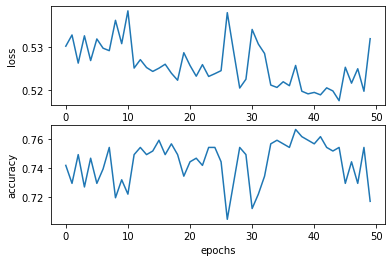

In [50]:
hist1 = train(model1, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=32, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=50, 
              description='dense64relu_dense1sigmoid_adam')

losses, accs = hist1['val_loss'], hist1['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Experimento 2

**Hipotesis:** La arquitectura de unicamente una capa oculta con 64 neuronas activadas por la funcion relu proveeran una exactitud superior al 70% tras entrenar durante 75 epochs, con un batch size de 64 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/75
19/19 [==============================] - 1s 10ms/step - loss: 0.4906 - accuracy: 0.7661 - val_loss: 0.5272 - val_accuracy: 0.7270
Epoch 2/75
19/19 [==============================] - 0s 3ms/step - loss: 0.4920 - accuracy: 0.7603 - val_loss: 0.5168 - val_accuracy: 0.7618
Epoch 3/75
19/19 [==============================] - 0s 3ms/step - loss: 0.4874 - accuracy: 0.7645 - val_loss: 0.5201 - val_accuracy: 0.7444
Epoch 4/75
19/19 [==============================] - 0s 2ms/step - loss: 0.4897 - accuracy: 0.7603 - val_loss: 0.5181 - val_accuracy: 0.7643
Epoch 5/75
19/19 [==============================] - 0s 2ms/step - loss: 0.4877 - accuracy: 0.7719 - val_loss: 0.5215 - val_accuracy: 0.7419
Epoch 6/75
19/19 [==============================] - 0s 2ms/step - loss: 0.4886 - accuracy: 0.7661 - val_loss: 0.5175 - val_accuracy: 0.7593
Epoch 7/75
19/19 [==============================] - 0s 2ms/step - loss: 0.4880 - accuracy: 0.7620 - val_loss: 0.5161 - val_accuracy: 0.7618
Epoch 8/75
19/19 [=

Text(0, 0.5, 'accuracy')

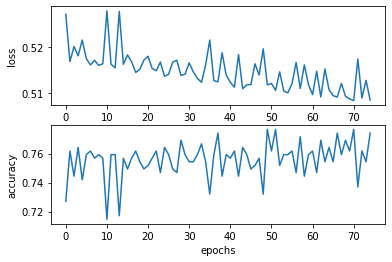

In [51]:
hist2 = train(model1, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=64, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=75, 
              description='dense64relu_dense1sigmoid_adam')

losses, accs = hist2['val_loss'], hist2['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Experimento 3

**Hipotesis:** La arquitectura de unicamente una capa oculta con 64 neuronas activadas por la funcion relu proveeran una exactitud superior al 90% tras entrenar durante 75 epochs, con un batch size de 256 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/75
5/5 [==============================] - 1s 52ms/step - loss: 0.4805 - accuracy: 0.7678 - val_loss: 0.5117 - val_accuracy: 0.7593
Epoch 2/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4762 - accuracy: 0.7760 - val_loss: 0.5078 - val_accuracy: 0.7742
Epoch 3/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4761 - accuracy: 0.7760 - val_loss: 0.5084 - val_accuracy: 0.7643
Epoch 4/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4745 - accuracy: 0.7736 - val_loss: 0.5106 - val_accuracy: 0.7618
Epoch 5/75
5/5 [==============================] - 0s 6ms/step - loss: 0.4748 - accuracy: 0.7719 - val_loss: 0.5090 - val_accuracy: 0.7643
Epoch 6/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4748 - accuracy: 0.7736 - val_loss: 0.5078 - val_accuracy: 0.7618
Epoch 7/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4743 - accuracy: 0.7736 - val_loss: 0.5089 - val_accuracy: 0.7593
Epoch 8/75
5/5 [=================

Epoch 60/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4708 - accuracy: 0.7760 - val_loss: 0.5066 - val_accuracy: 0.7618
Epoch 61/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4696 - accuracy: 0.7752 - val_loss: 0.5085 - val_accuracy: 0.7593
Epoch 62/75
5/5 [==============================] - 0s 6ms/step - loss: 0.4701 - accuracy: 0.7760 - val_loss: 0.5087 - val_accuracy: 0.7568
Epoch 63/75
5/5 [==============================] - 0s 6ms/step - loss: 0.4696 - accuracy: 0.7736 - val_loss: 0.5070 - val_accuracy: 0.7618
Epoch 64/75
5/5 [==============================] - 0s 6ms/step - loss: 0.4698 - accuracy: 0.7744 - val_loss: 0.5068 - val_accuracy: 0.7618
Epoch 65/75
5/5 [==============================] - 0s 6ms/step - loss: 0.4693 - accuracy: 0.7727 - val_loss: 0.5084 - val_accuracy: 0.7593
Epoch 66/75
5/5 [==============================] - 0s 7ms/step - loss: 0.4695 - accuracy: 0.7744 - val_loss: 0.5080 - val_accuracy: 0.7618
Epoch 67/75
5/5 [==========

Text(0, 0.5, 'accuracy')

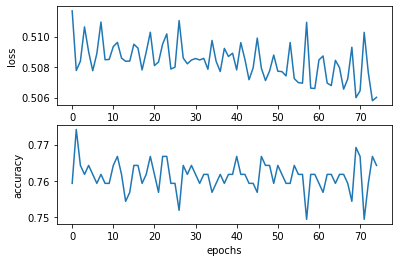

In [52]:
hist2 = train(model1, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=256, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=75, 
              description='dense64relu_dense1sigmoid_adam')

losses, accs = hist2['val_loss'], hist2['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Arquitectura 2

In [45]:
model2 = Sequential()
model2.add(Dense(32, input_dim=12, activation='tanh', kernel_initializer='uniform'))
model2.add(Dense(16, input_dim=12, activation='tanh', kernel_initializer='uniform'))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 32)                416       
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


### Experimento 4

**Hipotesis:** La arquitectura de unicamente 2 capas ocultas, 1 capa con 32 neuronas, la segunda compuesta por 16 neuronas, ambas activadas por la funcion tanh proveeran una exactitud superior al 70% tras entrenar durante 50 epochs, con un batch size de 32 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/50
38/38 [==============================] - 1s 5ms/step - loss: 0.6273 - accuracy: 0.6570 - val_loss: 0.6280 - val_accuracy: 0.6203
Epoch 2/50
38/38 [==============================] - 0s 2ms/step - loss: 0.6244 - accuracy: 0.6570 - val_loss: 0.6235 - val_accuracy: 0.6675
Epoch 3/50
38/38 [==============================] - 0s 2ms/step - loss: 0.6235 - accuracy: 0.6736 - val_loss: 0.6226 - val_accuracy: 0.6278
Epoch 4/50
38/38 [==============================] - 0s 2ms/step - loss: 0.6255 - accuracy: 0.6579 - val_loss: 0.6255 - val_accuracy: 0.6774
Epoch 5/50
38/38 [==============================] - 0s 2ms/step - loss: 0.6247 - accuracy: 0.6636 - val_loss: 0.6289 - val_accuracy: 0.6774
Epoch 6/50
38/38 [==============================] - 0s 2ms/step - loss: 0.6243 - accuracy: 0.6537 - val_loss: 0.6227 - val_accuracy: 0.6402
Epoch 7/50
38/38 [==============================] - 0s 2ms/step - loss: 0.6229 - accuracy: 0.6661 - val_loss: 0.6251 - val_accuracy: 0.6700
Epoch 8/50
38/38 [==

Text(0, 0.5, 'accuracy')

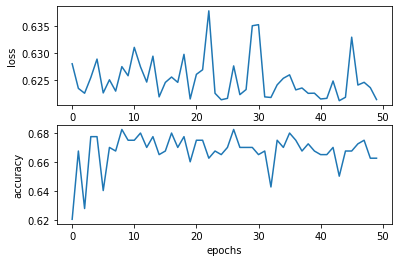

In [53]:
hist1 = train(model2, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=32, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=50, 
              description='dense32tanh_dense16tanh_dense1sigmoid_adam')

losses, accs = hist1['val_loss'], hist1['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Experimento 5

**Hipotesis:** La arquitectura de unicamente 2 capas ocultas, 1 capa con 32 neuronas, la segunda compuesta por 16 neuronas, ambas activadas por la funcion tanh proveeran una exactitud superior al 80% tras entrenar durante 50 epochs, con un batch size de 128 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/50
10/10 [==============================] - 1s 19ms/step - loss: 0.6234 - accuracy: 0.6636 - val_loss: 0.6255 - val_accuracy: 0.6774
Epoch 2/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6661 - val_loss: 0.6218 - val_accuracy: 0.6650
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6236 - accuracy: 0.6661 - val_loss: 0.6276 - val_accuracy: 0.6749
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.6711 - val_loss: 0.6219 - val_accuracy: 0.6700
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6232 - accuracy: 0.6645 - val_loss: 0.6229 - val_accuracy: 0.6749
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6579 - val_loss: 0.6223 - val_accuracy: 0.6725
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6645 - val_loss: 0.6252 - val_accuracy: 0.6849
Epoch 8/50
10/10 [=

Text(0, 0.5, 'accuracy')

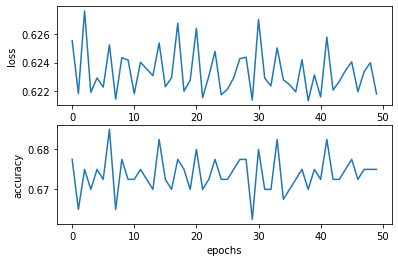

In [54]:
hist1 = train(model2, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=128, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=50, 
              description='dense32tanh_dense16tanh_dense1sigmoid_adam')

losses, accs = hist1['val_loss'], hist1['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Arquitectura 3

In [48]:
model3 = Sequential()
model3.add(Dense(64, input_dim=12, activation='relu', kernel_initializer='uniform'))
model3.add(Dense(32, activation='relu', kernel_initializer='uniform'))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


### Experimento 6

**Hipotesis:** La arquitectura de unicamente 2 capas ocultas, 1 capa con 64 neuronas, la segunda compuesta por 32 neuronas, ambas activadas por la funcion relu proveeran una exactitud superior al 70% tras entrenar durante 50 epochs, con un batch size de 32 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/50
38/38 [==============================] - 1s 5ms/step - loss: 0.5284 - accuracy: 0.7397 - val_loss: 0.5471 - val_accuracy: 0.7072
Epoch 2/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5194 - accuracy: 0.7463 - val_loss: 0.5409 - val_accuracy: 0.7270
Epoch 3/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5215 - accuracy: 0.7421 - val_loss: 0.5370 - val_accuracy: 0.7295
Epoch 4/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5187 - accuracy: 0.7413 - val_loss: 0.5363 - val_accuracy: 0.7171
Epoch 5/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5162 - accuracy: 0.7479 - val_loss: 0.5412 - val_accuracy: 0.7246
Epoch 6/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5174 - accuracy: 0.7488 - val_loss: 0.5332 - val_accuracy: 0.7345
Epoch 7/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5169 - accuracy: 0.7446 - val_loss: 0.5349 - val_accuracy: 0.7196
Epoch 8/50
38/38 [==

Text(0, 0.5, 'accuracy')

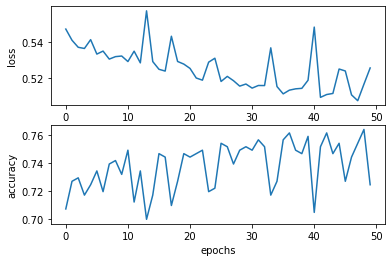

In [55]:
hist1 = train(model3, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=32, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=50, 
              description='dense64relu_dense32relu_dense1sigmoid_adam')

losses, accs = hist1['val_loss'], hist1['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Experimento 7

**Hipotesis:** La arquitectura de unicamente 2 capas ocultas, 1 capa con 64 neuronas, la segunda compuesta por 32 neuronas, ambas activadas por la funcion relu proveeran una exactitud superior al 70% tras entrenar durante 50 epochs, con un batch size de 128 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/50
10/10 [==============================] - 1s 20ms/step - loss: 0.4719 - accuracy: 0.7826 - val_loss: 0.5217 - val_accuracy: 0.7295
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.4703 - accuracy: 0.7777 - val_loss: 0.5078 - val_accuracy: 0.7519
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.4642 - accuracy: 0.7884 - val_loss: 0.5084 - val_accuracy: 0.7519
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.4637 - accuracy: 0.7785 - val_loss: 0.5130 - val_accuracy: 0.7444
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.4651 - accuracy: 0.7694 - val_loss: 0.5159 - val_accuracy: 0.7444
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.4653 - accuracy: 0.7818 - val_loss: 0.5084 - val_accuracy: 0.7469
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.4623 - accuracy: 0.7860 - val_loss: 0.5090 - val_accuracy: 0.7469
Epoch 8/50
10/10 [=

Text(0, 0.5, 'accuracy')

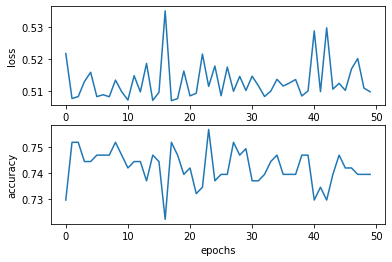

In [56]:
hist1 = train(model3, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=128, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=50, 
              description='dense64relu_dense32relu_dense1sigmoid_adam')

losses, accs = hist1['val_loss'], hist1['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Experimento 8

**Hipotesis:** La arquitectura de unicamente 2 capas ocultas, 1 capa con 64 neuronas, la segunda compuesta por 32 neuronas, ambas activadas por la funcion relu proveeran una exactitud superior al 70% tras entrenar durante 50 epochs, con un batch size de 256 observaciones, utilizando el optimizador adam y la funcion de costo binary crossentropy.

Epoch 1/50
5/5 [==============================] - 1s 41ms/step - loss: 0.4508 - accuracy: 0.7917 - val_loss: 0.5154 - val_accuracy: 0.7419
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4475 - accuracy: 0.7926 - val_loss: 0.5096 - val_accuracy: 0.7444
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4429 - accuracy: 0.7967 - val_loss: 0.5141 - val_accuracy: 0.7494
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4429 - accuracy: 0.7917 - val_loss: 0.5097 - val_accuracy: 0.7444
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4412 - accuracy: 0.7934 - val_loss: 0.5135 - val_accuracy: 0.7519
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4420 - accuracy: 0.7950 - val_loss: 0.5101 - val_accuracy: 0.7419
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 0.4424 - accuracy: 0.7934 - val_loss: 0.5143 - val_accuracy: 0.7494
Epoch 8/50
5/5 [=================

Text(0, 0.5, 'accuracy')

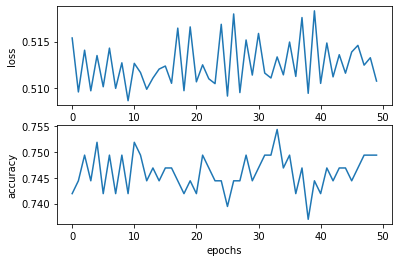

In [57]:
hist1 = train(model3, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=256, 
              optimizer='adam', 
              loss_fn='binary_crossentropy', 
              epochs=50, 
              description='dense64relu_dense32relu_dense1sigmoid_adam')

losses, accs = hist1['val_loss'], hist1['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Arquitectura 4

In [155]:
init = tf.keras.initializers.GlorotNormal(seed=None)
model4 = Sequential()
model4.add(Dense(128, input_dim=12, activation='relu', kernel_initializer=init))
model4.add(BatchNormalization())
model4.add(Dense(64, activation='relu', kernel_initializer=init))
model4.add(BatchNormalization())
model4.add(Dense(32, activation='relu', kernel_initializer=init))
model4.add(Dropout(0.1))
model4.add(Dense(1, activation='sigmoid'))
model4.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_207 (Dense)            (None, 128)               1664      
_________________________________________________________________
batch_normalization_19 (Batc (None, 128)               512       
_________________________________________________________________
dense_208 (Dense)            (None, 64)                8256      
_________________________________________________________________
batch_normalization_20 (Batc (None, 64)                256       
_________________________________________________________________
dense_209 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_210 (Dense)            (None, 1)               

### Experimento 9

**Hipotesis:** La arquitectura descrita a continuacion tras entrenar durante 175 epochs, con un batch size de 1000 observaciones, utilizando el optimizador adamax y la funcion de costo binary crossentropy proveeran una exactitud superior al 80% .
* 3 capas ocultas, 1 capa con 128 neuronas, la segunda compuesta por 64 neuronas y 32 neuronas en la tercera, ambas activadas por la funcion relu .
* 2 capas de normalizacion del output continuas a las salidas de las capas densas
* 1 capa de dropout para castigar el sobre ajuste al desactivar el 10% de las salidas de la ultima capa oculta

Epoch 1/175
2/2 [==============================] - 1s 255ms/step - loss: 0.1702 - accuracy: 0.9355 - val_loss: 1.0162 - val_accuracy: 0.7976
Epoch 2/175
2/2 [==============================] - 0s 31ms/step - loss: 0.2552 - accuracy: 0.9077 - val_loss: 0.9211 - val_accuracy: 0.8155
Epoch 3/175
2/2 [==============================] - 0s 27ms/step - loss: 0.1713 - accuracy: 0.9365 - val_loss: 0.8813 - val_accuracy: 0.8135
Epoch 4/175
2/2 [==============================] - 0s 31ms/step - loss: 0.1657 - accuracy: 0.9355 - val_loss: 0.8511 - val_accuracy: 0.8135
Epoch 5/175
2/2 [==============================] - 0s 28ms/step - loss: 0.1990 - accuracy: 0.9236 - val_loss: 0.8238 - val_accuracy: 0.8234
Epoch 6/175
2/2 [==============================] - 0s 25ms/step - loss: 0.1981 - accuracy: 0.9177 - val_loss: 0.8432 - val_accuracy: 0.8234
Epoch 7/175
2/2 [==============================] - 0s 46ms/step - loss: 0.1973 - accuracy: 0.9147 - val_loss: 0.8761 - val_accuracy: 0.8214
Epoch 8/175
2/2 [==

2/2 [==============================] - 0s 23ms/step - loss: 0.1662 - accuracy: 0.9355 - val_loss: 0.7928 - val_accuracy: 0.8115
Epoch 118/175
2/2 [==============================] - 0s 23ms/step - loss: 0.1616 - accuracy: 0.9375 - val_loss: 0.7906 - val_accuracy: 0.8135
Epoch 119/175
2/2 [==============================] - 0s 23ms/step - loss: 0.1558 - accuracy: 0.9415 - val_loss: 0.7858 - val_accuracy: 0.8115
Epoch 120/175
2/2 [==============================] - 0s 23ms/step - loss: 0.1596 - accuracy: 0.9395 - val_loss: 0.7863 - val_accuracy: 0.8016
Epoch 121/175
2/2 [==============================] - 0s 23ms/step - loss: 0.1687 - accuracy: 0.9375 - val_loss: 0.7783 - val_accuracy: 0.8016
Epoch 122/175
2/2 [==============================] - 0s 23ms/step - loss: 0.1408 - accuracy: 0.9464 - val_loss: 0.7836 - val_accuracy: 0.7956
Epoch 123/175
2/2 [==============================] - 0s 26ms/step - loss: 0.1434 - accuracy: 0.9425 - val_loss: 0.7836 - val_accuracy: 0.7996
Epoch 124/175
2/2 [=

Epoch 175/175
2/2 [==============================] - 0s 21ms/step - loss: 0.1578 - accuracy: 0.9296 - val_loss: 0.7193 - val_accuracy: 0.8036
Done!


Text(0, 0.5, 'accuracy')

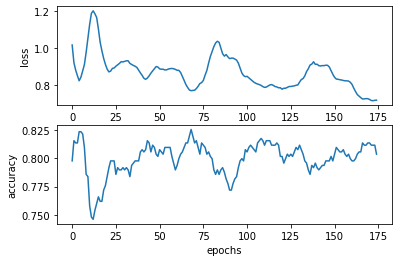

In [165]:
hist1 = train(model4, 
              train=[x_train, y_train], 
              test=[x_test, y_test], 
              batch_size=1000, 
              optimizer='adamax', 
              loss_fn='binary_crossentropy', 
              epochs=175, 
              description='dense128relu_dense64relu_dense32relu_dense1sigmoid_adam')

losses, accs = hist1['val_loss'], hist1['val_accuracy']
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

#### Validation

Para la validacion se utilizara el mejor modelo obtenido por la experimentacion anterior, el mejor modelo es el de la arquitectura numero 4.

In [170]:
loss, acc = model4.evaluate(x_validation, y_validation, verbose=None)
print(f"VALIDATION ACCURACY: {acc}")

VALIDATION ACCURACY: 0.8035714030265808


#### Conclusiones

## Parte 2

#### librerias

In [ ]:
from tensorflow.keras.layers     import Conv2D, Flatten, Dense, MaxPool2D
from sklearn.metrics             import classification_report
from sklearn.model_selection     import train_test_split
from tensorflow.keras            import Sequential
from sklearn.metrics             import confusion_matrix


import matplotlib.pyplot as plt
import pandas            as pd
import numpy             as np
import cv2
import os

In [ ]:
image = cv2.imread('../paris.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#### Dataset

#### Data Preparation

In [ ]:
labels = pd.read_csv('./parte2/data/labels.csv')

In [ ]:
dataset = []
lbls = []

def rescale_frame(frame, percent=75):
    dim = (536, 356)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

for asset in os.listdir('./parte2/data/photos'):
    label = labels[labels['ID'] == int(asset.replace(".png", ""))] \
                .drop(columns=['ID', 'Disease_Risk']) \
                .to_numpy()[0]
    tmp = cv2.imread(f'./parte2/data/photos/{asset}')
    rescaled_tmp = rescale_frame(tmp, 25)
    dataset.append(rescaled_tmp)
    lbls.append(label)
    
dataset = np.array(dataset)
lbls = np.array(lbls)

np.save('D:/parte2/data/features.npy', dataset)
np.save('D:/parte2/data/labels.npy', lbls)
print('Done!')

In [ ]:
features = np.load('D:/parte2/data/features.npy', allow_pickle=True)
labels = np.load('D:/parte2/data/labels.npy', allow_pickle=True)
features.shape, labels.shape

In [ ]:
plt.imshow(features[0])
plt.show()

#### Definicion arquitectura

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.4, random_state=42)
x_test, x_validation, y_test, y_validation = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
x_train.shape, x_test.shape, x_validation.shape, y_train.shape, y_test.shape, y_validation.shape

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(356, 536, 3), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Flatten())
cnn.add(Dense(units=64, activation='relu'))
cnn.add(Dense(units=45, activation='sigmoid'))
# cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cnn.fit(x_train, y_train, epochs=2)

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#### Experimentacion

In [ ]:
def train(model, train, test, batch_size, optimizer, loss_fn, epochs, description):
    filepath = f'./parte2/experiments/{description}_batch={batch_size}_epochs={epochs}'
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=1, save_weights_only=1, mode='max')
    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    x_train, y_train = train[0], train[1]
    x_test, y_test = test[0], test[1]
    
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint_callback])
    
    print("Done!")
    return history.history

In [ ]:
train_params = train(cnn, [x_train, y_train], [x_test, y_test], 64, 'adam', 'categorical_crossentropy', 1, 
      'conv64_maxpool2_conv32_maxpool2_relu64_sigmoid45')

In [ ]:
train_params.keys()

#### Conclusiones

## Parte 3

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#### Dataset

In [ ]:
for coin in os.listdir('./parte3/data/'):
    print(f'./parte3/data/{coin}')
    raw = pd.read_csv(f'./parte3/data/{coin}')
    dataset = raw[['Date', 'Close']].rename(columns={'Close': 'Price'})
    dataset['Date'] = dataset['Date'].apply(lambda x: str(x)[:10])
    plt.figure(figsize=(15, 5))
    plt.plot(dataset['Price'])
    plt.xlabel('Date')
    plt.ylabel('Price in dollars')
    plt.title(f'{coin[6:]} All history price')
    plt.show()

In [2]:
raw = pd.read_csv("./parte3/data/data.csv")
dataset = raw[['Date', 'Close']].rename(columns={'Close': 'Price'})
dataset['Date'] = dataset['Date'].apply(lambda x: str(x)[:10])
dataset.head()

,Date,Price
0,2013-04-29,144.539993
1,2013-04-30,139.000000
2,2013-05-01,116.989998
3,2013-05-02,105.209999
4,2013-05-03,97.750000


In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset['Price'] = scaler.fit_transform(dataset[['Price']])
dataset.head()

,Date,Price
0,2013-04-29,0.001200
1,2013-04-30,0.001112
2,2013-05-01,0.000765
3,2013-05-02,0.000580
4,2013-05-03,0.000462


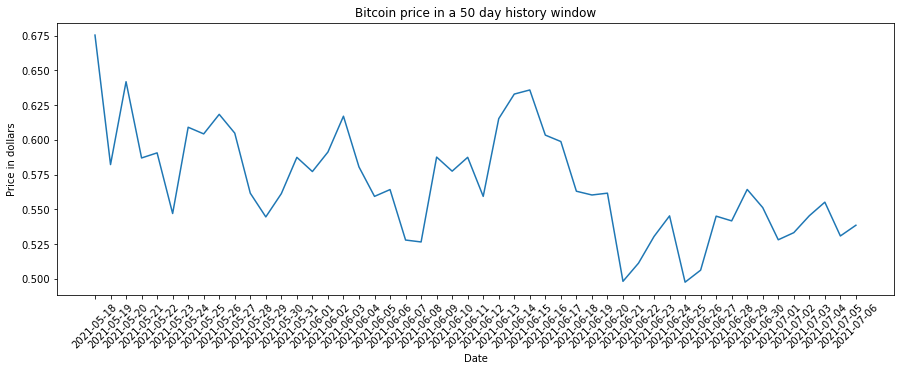

In [4]:
window = 50
plt.figure(figsize=(15, 5))
plt.plot(dataset['Date'][-window:], dataset['Price'][-window:])
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.xticks(rotation=45)
plt.title(f'Bitcoin price in a {window} day history window')
plt.show()

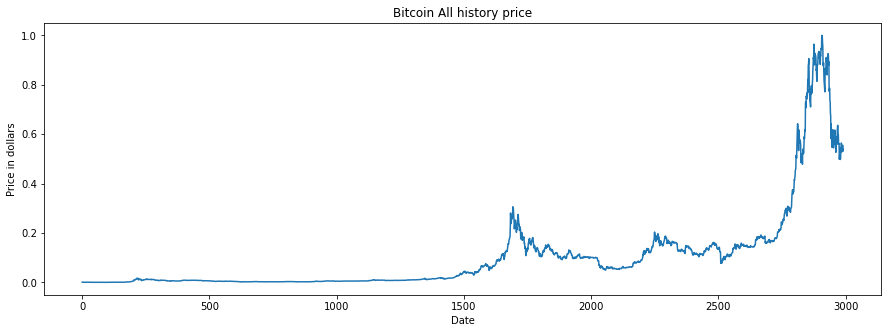

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(dataset['Price'])
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.title(f'Bitcoin All history price')
plt.show()

In [6]:
x_window = 5
y_window = 1
x = []
y = []

for x_w in range(0, len(dataset['Price']) - x_window - y_window - 1, x_window + y_window):
    x.append(dataset['Price'][x_w: x_w + x_window])
    y.append(dataset['Price'][x_w + x_window: x_w + x_window + y_window])
    
x, y = np.array(x), np.array(y)
x = x.reshape((x.shape[0], 1, x_window))
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, shuffle = False, stratify = None)
x_test, x_validation, y_test, y_validation = train_test_split(x_temp, y_temp, test_size=0.5, shuffle = False, stratify = None)

In [27]:
def train(model, train, test, batch_size, optimizer, loss_fn, epochs, description):
    filepath = f'./parte3/experiments/{description}_batch={batch_size}_epochs={epochs}'
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=1, save_weights_only=1, mode='max')
    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['mean_squared_error'])
    x_train, y_train = train[0], train[1]
    x_test, y_test = test[0], test[1]
    
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint_callback])
    
    print("Done!")
    return history

### Experimentacion

### Arquitectura 1

In [23]:
model = Sequential()
model.add(LSTM(5, input_shape=(1, x_window)))
model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

Epoch 1/100
3/3 [==============================] - 3s 276ms/step - loss: 8.5559e-05 - mean_squared_error: 8.5559e-05 - val_loss: 1.6205e-04 - val_mean_squared_error: 1.6205e-04
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 7.8761e-05 - mean_squared_error: 7.8761e-05 - val_loss: 1.0516e-04 - val_mean_squared_error: 1.0516e-04
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 9.1187e-05 - mean_squared_error: 9.1187e-05 - val_loss: 7.8608e-05 - val_mean_squared_error: 7.8608e-05
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 8.5332e-05 - mean_squared_error: 8.5332e-05 - val_loss: 7.0630e-05 - val_mean_squared_error: 7.0630e-05
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: 1.2861e-04 - mean_squared_error: 1.2861e-04 - val_loss: 6.8894e-05 - val_mean_squared_error: 6.8894e-05
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 1.1314e-04 - mean_squared_error: 1.1314e-04 - v

3/3 [==============================] - 0s 14ms/step - loss: 1.1912e-04 - mean_squared_error: 1.1912e-04 - val_loss: 5.4935e-05 - val_mean_squared_error: 5.4935e-05
Epoch 48/100
3/3 [==============================] - 0s 12ms/step - loss: 1.1386e-04 - mean_squared_error: 1.1386e-04 - val_loss: 5.3033e-05 - val_mean_squared_error: 5.3033e-05
Epoch 49/100
3/3 [==============================] - 0s 12ms/step - loss: 1.6424e-04 - mean_squared_error: 1.6424e-04 - val_loss: 1.0719e-04 - val_mean_squared_error: 1.0719e-04
Epoch 50/100
3/3 [==============================] - 0s 13ms/step - loss: 9.5616e-05 - mean_squared_error: 9.5616e-05 - val_loss: 1.9062e-04 - val_mean_squared_error: 1.9062e-04
Epoch 51/100
3/3 [==============================] - 0s 12ms/step - loss: 1.4103e-04 - mean_squared_error: 1.4103e-04 - val_loss: 1.7956e-04 - val_mean_squared_error: 1.7956e-04
Epoch 52/100
3/3 [==============================] - 0s 13ms/step - loss: 1.1723e-04 - mean_squared_error: 1.1723e-04 - val_loss:

3/3 [==============================] - 0s 13ms/step - loss: 8.5091e-05 - mean_squared_error: 8.5091e-05 - val_loss: 1.8177e-04 - val_mean_squared_error: 1.8177e-04
Epoch 94/100
3/3 [==============================] - 0s 14ms/step - loss: 8.9771e-05 - mean_squared_error: 8.9771e-05 - val_loss: 1.5329e-04 - val_mean_squared_error: 1.5329e-04
Epoch 95/100
3/3 [==============================] - 0s 13ms/step - loss: 1.0825e-04 - mean_squared_error: 1.0825e-04 - val_loss: 6.0548e-05 - val_mean_squared_error: 6.0548e-05
Epoch 96/100
3/3 [==============================] - 0s 13ms/step - loss: 1.2045e-04 - mean_squared_error: 1.2045e-04 - val_loss: 5.8294e-05 - val_mean_squared_error: 5.8294e-05
Epoch 97/100
3/3 [==============================] - 0s 13ms/step - loss: 1.1225e-04 - mean_squared_error: 1.1225e-04 - val_loss: 6.9972e-05 - val_mean_squared_error: 6.9972e-05
Epoch 98/100
3/3 [==============================] - 0s 13ms/step - loss: 1.7911e-04 - mean_squared_error: 1.7911e-04 - val_loss:

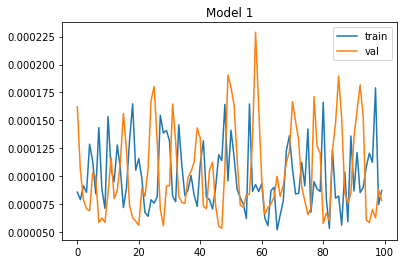

In [28]:
model1_hist = train(model, [x_train, y_train], [x_test, y_test], 128, 'adam', 'mean_squared_error', 100, 'lstm5_dropout1_dense64relu_dropout1_dense16relu_dropout1_denselinear')
plt.plot(model1_hist.history['loss'], label='train')
plt.plot(model1_hist.history['val_loss'], label='val')
plt.title('Model 1')
plt.legend()
plt.show()

Epoch 1/50
2/2 [==============================] - 3s 571ms/step - loss: 6.8481e-05 - mean_squared_error: 6.8481e-05 - val_loss: 2.2985e-04 - val_mean_squared_error: 2.2985e-04
Epoch 2/50
2/2 [==============================] - 0s 22ms/step - loss: 1.0856e-04 - mean_squared_error: 1.0856e-04 - val_loss: 3.5455e-04 - val_mean_squared_error: 3.5455e-04
Epoch 3/50
2/2 [==============================] - 0s 25ms/step - loss: 7.6900e-05 - mean_squared_error: 7.6900e-05 - val_loss: 1.8938e-04 - val_mean_squared_error: 1.8938e-04
Epoch 4/50
2/2 [==============================] - 0s 26ms/step - loss: 9.6068e-05 - mean_squared_error: 9.6068e-05 - val_loss: 9.5179e-05 - val_mean_squared_error: 9.5179e-05
Epoch 5/50
2/2 [==============================] - 0s 24ms/step - loss: 1.0823e-04 - mean_squared_error: 1.0823e-04 - val_loss: 7.7894e-05 - val_mean_squared_error: 7.7894e-05
Epoch 6/50
2/2 [==============================] - 0s 24ms/step - loss: 7.3566e-05 - mean_squared_error: 7.3566e-05 - val_los

2/2 [==============================] - 0s 23ms/step - loss: 9.5683e-05 - mean_squared_error: 9.5683e-05 - val_loss: 8.2301e-05 - val_mean_squared_error: 8.2301e-05
Epoch 48/50
2/2 [==============================] - 0s 25ms/step - loss: 7.4393e-05 - mean_squared_error: 7.4393e-05 - val_loss: 7.7769e-05 - val_mean_squared_error: 7.7769e-05
Epoch 49/50
2/2 [==============================] - 0s 24ms/step - loss: 6.1727e-05 - mean_squared_error: 6.1727e-05 - val_loss: 7.0607e-05 - val_mean_squared_error: 7.0607e-05
Epoch 50/50
2/2 [==============================] - 0s 23ms/step - loss: 5.1611e-05 - mean_squared_error: 5.1611e-05 - val_loss: 7.6845e-05 - val_mean_squared_error: 7.6845e-05
Done!


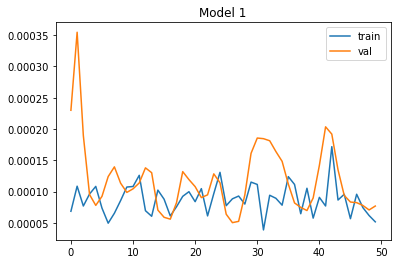

In [29]:
model1_hist = train(model, [x_train, y_train], [x_test, y_test], 256, 'adam', 'mean_squared_error', 50, 'lstm5_dropout1_dense64relu_dropout1_dense16relu_dropout1_denselinear')
plt.plot(model1_hist.history['loss'], label='train')
plt.plot(model1_hist.history['val_loss'], label='val')
plt.title('Model 1')
plt.legend()
plt.show()

Epoch 1/50
5/5 [==============================] - 3s 144ms/step - loss: 7.3579e-05 - mean_squared_error: 7.3579e-05 - val_loss: 3.6134e-04 - val_mean_squared_error: 3.6134e-04
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 8.7286e-05 - mean_squared_error: 8.7286e-05 - val_loss: 1.9100e-04 - val_mean_squared_error: 1.9100e-04
Epoch 3/50
5/5 [==============================] - 0s 9ms/step - loss: 8.5221e-05 - mean_squared_error: 8.5221e-05 - val_loss: 1.4889e-04 - val_mean_squared_error: 1.4889e-04
Epoch 4/50
5/5 [==============================] - 0s 9ms/step - loss: 7.8767e-05 - mean_squared_error: 7.8767e-05 - val_loss: 1.6553e-04 - val_mean_squared_error: 1.6553e-04
Epoch 5/50
5/5 [==============================] - 0s 9ms/step - loss: 8.9848e-05 - mean_squared_error: 8.9848e-05 - val_loss: 8.1322e-05 - val_mean_squared_error: 8.1322e-05
Epoch 6/50
5/5 [==============================] - 0s 9ms/step - loss: 1.0273e-04 - mean_squared_error: 1.0273e-04 - val_loss: 9.

Epoch 48/50
5/5 [==============================] - ETA: 0s - loss: 3.7287e-05 - mean_squared_error: 3.7287e- - 0s 8ms/step - loss: 9.9487e-05 - mean_squared_error: 9.9487e-05 - val_loss: 1.0731e-04 - val_mean_squared_error: 1.0731e-04
Epoch 49/50
5/5 [==============================] - 0s 9ms/step - loss: 5.5176e-05 - mean_squared_error: 5.5176e-05 - val_loss: 2.0091e-04 - val_mean_squared_error: 2.0091e-04
Epoch 50/50
5/5 [==============================] - 0s 9ms/step - loss: 9.6359e-05 - mean_squared_error: 9.6359e-05 - val_loss: 9.8635e-05 - val_mean_squared_error: 9.8635e-05
Done!


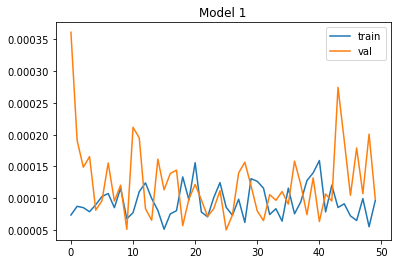

In [33]:
model1_hist = train(model, [x_train, y_train], [x_test, y_test], 64, 'adam', 'mean_squared_error', 50, 'lstm5_dropout1_dense64relu_dropout1_dense16relu_dropout1_denselinear')
plt.plot(model1_hist.history['loss'], label='train')
plt.plot(model1_hist.history['val_loss'], label='val')
plt.title('Model 1')
plt.legend()
plt.show()

### Arquitectura 2

In [31]:
model2 = Sequential()
model2.add(LSTM(5, input_shape=(1, x_window)))
model2.add(Dense(32, activation = 'relu'))
model2.add(Dense(16, activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='linear'))

Epoch 1/50
5/5 [==============================] - 3s 164ms/step - loss: 9.5504e-05 - mean_squared_error: 9.5504e-05 - val_loss: 6.6297e-05 - val_mean_squared_error: 6.6297e-05
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 1.0162e-04 - mean_squared_error: 1.0162e-04 - val_loss: 4.3148e-05 - val_mean_squared_error: 4.3148e-05
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 1.7160e-04 - mean_squared_error: 1.7160e-04 - val_loss: 4.2623e-05 - val_mean_squared_error: 4.2623e-05
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 1.4055e-04 - mean_squared_error: 1.4055e-04 - val_loss: 4.5453e-05 - val_mean_squared_error: 4.5453e-05
Epoch 5/50
5/5 [==============================] - 0s 8ms/step - loss: 1.0780e-04 - mean_squared_error: 1.0780e-04 - val_loss: 4.5073e-05 - val_mean_squared_error: 4.5073e-05
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 2.1966e-04 - mean_squared_error: 2.1966e-04 - val_loss: 4.

Epoch 48/50
5/5 [==============================] - 0s 8ms/step - loss: 1.2302e-04 - mean_squared_error: 1.2302e-04 - val_loss: 5.8472e-05 - val_mean_squared_error: 5.8472e-05
Epoch 49/50
5/5 [==============================] - 0s 8ms/step - loss: 9.5310e-05 - mean_squared_error: 9.5310e-05 - val_loss: 5.9458e-05 - val_mean_squared_error: 5.9458e-05
Epoch 50/50
5/5 [==============================] - 0s 8ms/step - loss: 1.2163e-04 - mean_squared_error: 1.2163e-04 - val_loss: 8.3257e-05 - val_mean_squared_error: 8.3257e-05
Done!


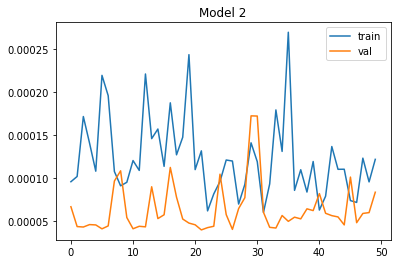

In [42]:
model2_hist = train(model2, [x_train, y_train], [x_test, y_test], 64, 'adam', 'mean_squared_error', 50, 'lstm5_dense32relu_dense16relu_dropout2_denselinear')
plt.plot(model2_hist.history['loss'], label='train')
plt.plot(model2_hist.history['val_loss'], label='val')
plt.title('Model 2')
plt.legend()
plt.show()

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 5.9351e-05 - mean_squared_error: 5.9351e-05 - val_loss: 1.1690e-04 - val_mean_squared_error: 1.1690e-04
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 1.8256e-04 - mean_squared_error: 1.8256e-04 - val_loss: 1.0160e-04 - val_mean_squared_error: 1.0160e-04
Epoch 3/50
1/1 [==============================] - 0s 26ms/step - loss: 1.0886e-04 - mean_squared_error: 1.0886e-04 - val_loss: 7.7491e-05 - val_mean_squared_error: 7.7491e-05
Epoch 4/50
1/1 [==============================] - 0s 27ms/step - loss: 1.0729e-04 - mean_squared_error: 1.0729e-04 - val_loss: 5.9230e-05 - val_mean_squared_error: 5.9230e-05
Epoch 5/50
1/1 [==============================] - 0s 26ms/step - loss: 1.1110e-04 - mean_squared_error: 1.1110e-04 - val_loss: 5.1785e-05 - val_mean_squared_error: 5.1785e-05
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 8.0828e-05 - mean_squared_error: 8.0828e-05 - val_loss: 

1/1 [==============================] - 0s 27ms/step - loss: 1.1535e-04 - mean_squared_error: 1.1535e-04 - val_loss: 4.4850e-05 - val_mean_squared_error: 4.4850e-05
Epoch 48/50
1/1 [==============================] - 0s 25ms/step - loss: 1.4787e-04 - mean_squared_error: 1.4787e-04 - val_loss: 4.0953e-05 - val_mean_squared_error: 4.0953e-05
Epoch 49/50
1/1 [==============================] - 0s 25ms/step - loss: 7.3227e-05 - mean_squared_error: 7.3227e-05 - val_loss: 4.1331e-05 - val_mean_squared_error: 4.1331e-05
Epoch 50/50
1/1 [==============================] - 0s 25ms/step - loss: 1.3103e-04 - mean_squared_error: 1.3103e-04 - val_loss: 4.2428e-05 - val_mean_squared_error: 4.2428e-05
Done!


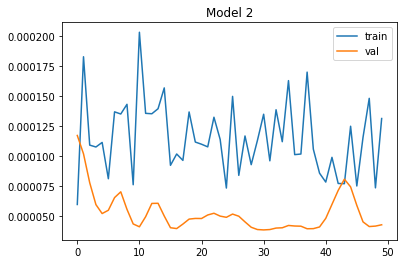

In [44]:
model2_hist = train(model2, [x_train, y_train], [x_test, y_test], 64, 'adam', 'mean_squared_error', 50, 'lstm5_dropout1_dense64relu_dropout1_dense16relu_dropout1_denselinear')
plt.plot(model2_hist.history['loss'], label='train')
plt.plot(model2_hist.history['val_loss'], label='val')
plt.title('Model 2')
plt.legend()
plt.show()

### Validation

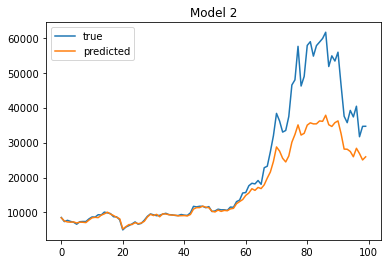

In [46]:
test_predictions = scaler.inverse_transform(model2.predict(x_validation))
plt.plot(scaler.inverse_transform(y_validation), label='true')
plt.plot(test_predictions, label='predicted')
plt.title('Model 2')
plt.legend()
plt.show()

#### Experimentacion

#### Conclusiones